In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
quality_map = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5}
df.loc[:,'quality'] = df.quality.map(quality_map)

In [5]:
df.shape

(1599, 12)

In [6]:
# Shuffle and reset index
df = df.sample(frac=1).reset_index(drop=True)
# Get 1000 rows for training, and 599 rows for testing
df_train = df.head(1000)
df_test = df.tail(599)

### Train a decision tree

In [7]:
# Train a decision tree
from sklearn import tree
from sklearn import metrics
# Create a decision tree
N = 7 # max depth of tree
clf = tree.DecisionTreeClassifier(max_depth=N)
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(max_depth=7)

In [8]:
# Predict
train_preds = clf.predict(df_train[cols])
test_preds = clf.predict(df_test[cols])
# Get accuracy
train_acc = metrics.accuracy_score(df_train.quality, train_preds)
test_acc  = metrics.accuracy_score(df_test.quality, test_preds)
train_acc, test_acc

(0.765, 0.5726210350584308)

### Check overfitting with different tree max_depth

In [9]:
def get_accuracy(df, cols, target, max_depth):
    # get train, test datasets
    df_train = df.head(1000)
    df_test = df.tail(599)
    # Train a decision tree
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(df_train[cols],df_train[target])
    # Predict
    train_preds = clf.predict(df_train[cols])
    test_preds = clf.predict(df_test[cols])
    # Get accuracy
    train_acc = metrics.accuracy_score(df_train.quality, train_preds)
    test_acc  = metrics.accuracy_score(df_test.quality, test_preds)
    return train_acc, test_acc    

In [10]:
train_accs = [0.5]
test_accs = [0.5]

cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
target = 'quality'
for n in range(30):
    train_acc, test_acc = get_accuracy(df, cols, target, n+1)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

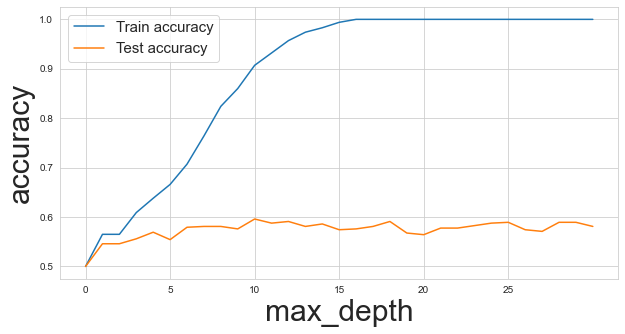

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accs, label='Train accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend(loc='upper left', prop={'size':15})
plt.xticks(range(0,26,5))
plt.xlabel("max_depth", size=30)
plt.ylabel("accuracy", size=30)
plt.show()

### K-fold cross-validation

In [12]:
import pandas as pd
from sklearn import model_selection

In [13]:
df = pd.read_csv('./data/cat_train.csv')
df.shape

(600000, 26)

In [14]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,kfold
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0,-1
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0,-1
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0,-1
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0,-1
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0,-1


In [15]:
df['kfold'] = -1
# Randomise data
df = df.sample(frac=1).reset_index(drop=True)
kf = model_selection.KFold(n_splits=5)
# Fill the new kfold column
for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold
# Save to csv file
df.to_csv("./data/cat_train_fold_2021.csv")


sklearn.model_selection._split.KFold

### Stratified KFold

In [18]:
df['kfold'] = -1
# Randomise data
df = df.sample(frac=1).reset_index(drop=True)
y = df.target.values
kf = model_selection.StratifiedKFold(n_splits=5)
# Fill the new kfold column
for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
    df.loc[val_, 'kfold'] = fold
# Save to csv file
df.to_csv("./data/cat_train_fold_2022.csv")